In [1]:
PROJECT_ID = 'dwh-siloam'
REGION = 'asia-southeast1'
print(f"Project ID: {PROJECT_ID}\nRegion: {REGION}")

# Initialize Vertex AI
from pathlib import Path
import vertexai
from google.cloud import aiplatform

print(f"Checking Credentials...")
if not any((Path.cwd()/"service_account").glob('*.json')):
    print("Service account folder is empty. Fallback using default gcloud account")
    aiplatform.init(project=PROJECT_ID, location=REGION)
    vertexai.init(project=PROJECT_ID, location=REGION)
else:
    print('Using service account credentials from service_account folder')
    from google.oauth2 import service_account
    sa_file = list((Path.cwd()/"service_account").glob('*.json'))[0]
    print(f"Using service account file: {sa_file}")
    credentials = service_account.Credentials.from_service_account_file(sa_file)
    aiplatform.init(project=PROJECT_ID, location=REGION, credentials=credentials)
    vertexai.init(project=PROJECT_ID, location=REGION, credentials=credentials)

# Import libraries
from langchain_google_vertexai import (
    VertexAI, 
    ChatVertexAI, 
    VertexAIEmbeddings
)
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

from typing import List, Optional
import requests

from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import MessagesPlaceholder
from settings import CopilotSettings
import time

Project ID: dwh-siloam
Region: asia-southeast1
Checking Credentials...
Using service account credentials from service_account folder
Using service account file: /Users/donnymirzaadhitama/workspace/others/chatbot-llm/service_account/dwh-siloam-99402e61edd2.json


In [2]:
import os
from pandasai import SmartDataframe, SmartDatalake
import pandas as pd
from pandasai import Agent
from pandasai.connectors import GoogleBigQueryConnector
from pandasai.ee.vectorstores import ChromaDB, Qdrant


In [3]:
PANDASAI_API_KEY = "$2a$10$KwsNJeV.2XVPza4Ca8x9fOyMAhti4IgqBdI0vIfGg7p46b4k2EkrW"
os.environ["PANDASAI_API_KEY"] = PANDASAI_API_KEY

In [4]:
# os.environ["LANGCHAIN_API_KEY"] = "ls__0f29968aab6d4fdeac9159bee2e411b1"
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
# os.environ["LANGCHAIN_PROJECT"] = "opensource-llm"

# from langsmith import Client
# client = Client()

## Test using scratch dataframe

In [4]:
df = pd.DataFrame({
    "country": [
        "United States",
        "United Kingdom",
        "France",
        "Germany",
        "Italy",
        "Spain",
        "Canada",
        "Australia",
        "Japan",
        "China",
    ],
    "gdp": [
        19294482071552,
        2891615567872,
        2411255037952,
        3435817336832,
        1745433788416,
        1181205135360,
        1607402389504,
        1490967855104,
        4380756541440,
        14631844184064,
    ],
    "happiness_index": [6.94, 7.16, 6.66, 7.07, 6.38, 6.4, 7.23, 7.22, 5.87, 5.12],
})

df.head()

,country,gdp,happiness_index
0,United States,19294482071552,6.94
1,United Kingdom,2891615567872,7.16
2,France,2411255037952,6.66
3,Germany,3435817336832,7.07
4,Italy,1745433788416,6.38


### Test using default LLM of PandasAI

In [5]:
sdf = SmartDataframe(df)

In [7]:
response = sdf.chat("Negara mana dengan GDP tertinggi? Dan berapa GDP-nya?")
print(response)

Negara dengan GDP tertinggi adalah United States dengan GDP sebesar 19294482071552.


Proof it with pandas querying.

In [8]:
df.loc[df["gdp"] == df["gdp"].max()]

,country,gdp,happiness_index
0,United States,19294482071552,6.94


More test here:

### Test using VertexAI LLM (using csv file dataframe)

In [4]:
config = CopilotSettings()

In [5]:
llm = VertexAI(
    model_name=config.GCP_GEMINI_MODEL_NAME, 
    temperature=0, 
    max_output_tokens=8192
)

In [6]:
df_titanic = pd.read_csv("dataset/titanic/train.csv")
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
sdf_vertexai = SmartDataframe(
    df_titanic, 
    config={"llm": llm}
)

In [13]:
response = sdf_vertexai.chat("Berapa rata-rata umur penumpang laki-laki yang selamat?")
print(response)

27.276021505376345


Proof it!

In [14]:
df_titanic.loc[(df_titanic["Sex"] == "male") & (df_titanic["Survived"] == 1)]["Age"].mean()

27.276021505376345

### Visualization answer example

'/Users/donnymirzaadhitama/workspace/others/chatbot-llm/exports/charts/temp_chart.png'

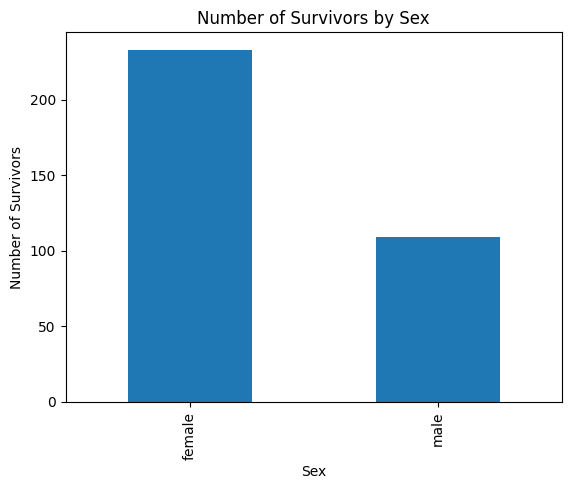

In [14]:
sdf_vertexai.chat("Apakah penumpang laki-laki atau perempuan yang paling banyak selamat?")

More test here:

In [11]:
response = sdf_vertexai.chat("Siapa presiden Guatemala?")
print(response)

I cannot answer this question. I can only process the given data.


In [18]:
print(sdf_vertexai.last_code_executed)

df = dfs[0]
df_not_survived = df[df['Survived'] == 0]
age_by_sex = df_not_survived.groupby(['Sex'])['Age'].mean().reset_index()
result = {'type': 'dataframe', 'value': age_by_sex}


## Query multiple dataframes using SmartDatalake

In [20]:
employees_data = {
    'EmployeeID': [1, 2, 3, 4, 5],
    'Name': ['John', 'Emma', 'Liam', 'Olivia', 'William'],
    'Department': ['HR', 'Sales', 'IT', 'Marketing', 'Finance']
}

salaries_data = {
    'EmployeeID': [1, 2, 3, 4, 5],
    'Salary': [5000, 6000, 4500, 7000, 5500]
}

employees_df = pd.DataFrame(employees_data)
salaries_df = pd.DataFrame(salaries_data)

In [17]:
employees_df

,EmployeeID,Name,Department
0,1,John,HR
1,2,Emma,Sales
2,3,Liam,IT
3,4,Olivia,Marketing
4,5,William,Finance


In [18]:
salaries_df

,EmployeeID,Salary
0,1,5000
1,2,6000
2,3,4500
3,4,7000
4,5,5500


In [21]:
lake = SmartDatalake(
    [
        employees_df, 
        salaries_df
    ], 
    config={"llm": llm}
)

In [23]:
response = lake.chat("Siapa yang gajinya naik tiap tahun?")
print(response)

Employees with salary increase each year: Emma, John, Liam, Olivia, William


More test here:

## Agent (for multi-turn conversation)

In [21]:
sales_by_country = pd.DataFrame({
    "country": ["United States", "United Kingdom", "France", "Germany", "Italy", "Spain", "Canada", "Australia", "Japan", "China"],
    "sales": [5000, 3200, 2900, 4100, 2300, 2100, 2500, 2600, 4500, 7000],
    "deals_opened": [142, 80, 70, 90, 60, 50, 40, 30, 110, 120],
    "deals_closed": [120, 70, 60, 80, 50, 40, 30, 20, 100, 110]
})

agent = Agent(
    sales_by_country,
    config={"llm": llm}
)
agent.chat('Which are the top 5 countries by sales?')

,country,sales,deals_opened,deals_closed
9,China,7000,120,110
0,United States,5000,142,120
8,Japan,4500,110,100
3,Germany,4100,90,80
1,United Kingdom,3200,80,70


In [22]:
agent.chat('How about the top opened deals?')

,country,sales,deals_opened,deals_closed
0,United States,5000,142,120
9,China,7000,120,110
8,Japan,4500,110,100
3,Germany,4100,90,80
1,United Kingdom,3200,80,70


Using titanic dataset...

In [23]:
agent = Agent(
    df_titanic,
    config={"llm": llm}
)
response = agent.chat("Berapa rata-rata penumpang laki-laki yang meninggal?")
print(response)

30.72664459161148


In [24]:
explanation = agent.explain()
print(explanation)

 To calculate the average age of male passengers who died, we first need to select only the male passengers from the dataset. We can do this by filtering the dataset based on the 'Sex' column and selecting only the rows where the 'Sex' column is equal to 'male'.

Once we have the male passengers, we can calculate the average age of these passengers by using the 'mean()' function on the 'Age' column.

Finally, we can store the result in a variable and return it as the answer to the query.


In [25]:
print(agent.last_code_executed)

male_passengers = dfs[0][dfs[0]['Sex'] == 'male']
avg_age_male_passengers = male_passengers['Age'].mean()
result = {'type': 'number', 'value': avg_age_male_passengers}


/Users/donnymirzaadhitama/workspace/others/chatbot-llm/exports/charts/temp_chart.png


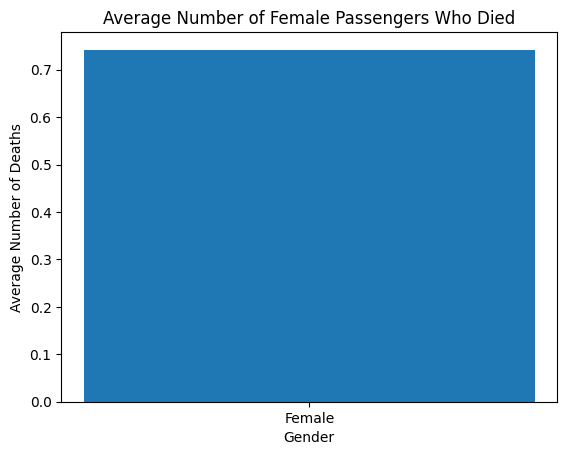

In [26]:
response = agent.chat("Bagaimana dengan penumpang perempuan?")
print(response)

In [27]:
explanation = agent.explain()
print(explanation)

 To calculate the average number of female passengers who died, we first need to filter the DataFrame to only include female passengers. We can do this by using the `[0]` operator to select the first DataFrame in the list of DataFrames, and then using the `['Sex'] == 'female'` operator to select only the rows where the `Sex` column is equal to `female`.

Once we have the DataFrame of female passengers, we can calculate the average number of deaths by using the `mean()` method on the `Survived` column. This will give us the average number of deaths for female passengers.

To display the results, we can use the `plt.bar()` function to create a bar chart. The first argument to `plt.bar()` is the label for the bar, and the second argument is the value of the bar. In this case, the label is `Female` and the value is the average number of deaths for female passengers.

We can then use the `plt.xlabel()` and `plt.ylabel()` functions to label the x-axis and y-axis of the chart, and the `plt.ti

Agent clarification

In [28]:
agent.clarification_questions("Bagaimana dengan penumpang") # gak terlalu guna

['Apakah yang dimaksud dengan penumpang adalah semua penumpang atau hanya penumpang yang selamat?',
 'Apakah yang dimaksud dengan penumpang perempuan adalah semua penumpang perempuan atau hanya penumpang perempuan yang meninggal?',
 'Apakah yang dimaksud dengan penumpang perempuan adalah semua penumpang perempuan atau hanya penumpang perempuan yang selamat?']

Rephrase question

In [29]:
rephrased = agent.rephrase_query("Kenapa penumpang meninggal")
print(rephrased)

 Apa penyebab kematian penumpang?


## Connect to BigQuery

In [7]:
field_descriptions_gwi = {
    "organization_id": "id for organization/hospital",
    "hospital_region": "region of hospital, such as Region 1, Region 2, etc",
    "hospital_type": "type of hospital, such as Mature, Flagship, Distinct, BPJS, Ramping Up, and Hospital Services",
    "archetype": "archetype of hospital, such as Value Seeker, Premium, and BPJS",
    "hospital_name": "name of hospital such as Siloam Hospitals Lippo Village, Siloam Hospitals Kebon Jeruk, MRCCC Siloam Hospitals Semanggi, etc",
    "hospital_address": "address of hospital such as Jl. Siloam No. 6, Lippo Village, Tangerang, Banten, Indonesia, Jl. Panjang No. 26, Kebon Jeruk, Jakarta Barat, DKI Jakarta, Indonesia, Jl. Garnisun Dalam No. 2-3, Karet Semanggi, Setiabudi, Jakarta Selatan, DKI Jakarta, Indonesia, etc",
    "hospital_code": "code of hospital unit such as SHLV, SHKJ, MRCCC, etc",
    "month": "month of year, such as 1, 2, 3, etc",
    "year": "year of data, such as 2023, 2022, etc",
    "gwi_score": "group wide indicator (gwi) score of siloam hospital",
    "rank_unit_top": "ranking of hospital unit based on gwi score at that period of data, 1 is the highest",
    "rank_unit_bottom": "ranking of hospital unit based on gwi score at that period of data, 1 is the lowest",
    "month_year": "month and year of data, such as 12022, 22022, etc",
    "quarter_year": "quarter and year of data, such as Q1-2022, Q2-2022, etc",
    "semester_year": "semester and year of data, such as S1-2022, S2-2022, etc",
}

/Users/donnymirzaadhitama/workspace/others/chatbot-llm/exports/charts/temp_chart.png


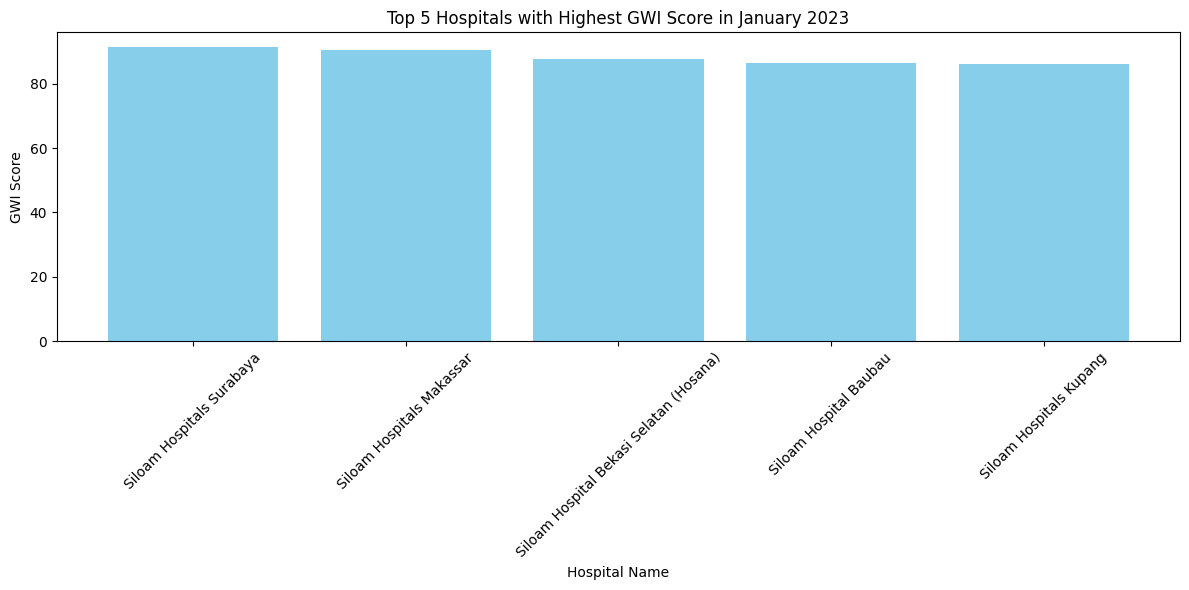

In [8]:
# ref: https://github.com/Sinaptik-AI/pandas-ai/issues/971
gwi_score_connector = GoogleBigQueryConnector(
    config={
        "credentials_path" : "service_account/dwh-siloam-99402e61edd2.json",
        "database" : "GWI_LLM",
        "table" : "gwi_score_view",
        "projectID" : "dwh-siloam",
        # "where": [
        #     # this is optional and filters the data to
        #     # reduce the size of the dataframe
        #     ["loan_status", "=", "PAIDOFF"],
        # ],
    },
    field_descriptions=field_descriptions_gwi,
)

df_gwi = SmartDataframe(gwi_score_connector)
response = df_gwi.chat("Tampilkan chart 5 hospital dengan gwi score tertinggi di bulan januari 2023")
print(response)

In [32]:
df_gwi.head_df

,organization_id,hospital_region,hospital_type,archetype,hospital_name,hospital_address,hospital_code,month,year,gwi_score,rank_unit_top,rank_unit_bottom,month_year,quarter_year,semester_year
0,27.0,Region 1,Distinct,Premium,Siloam Hospitals Asri,"Jl. Duren Tiga Raya No. 20 Jakarta, 12760",ASRI,5,2022,73.302052,15,26,52022,Q2-2022,S1-2022
1,3.0,Region 1,Flagship,Premium,Siloam Hospitals Kebon Jeruk,"Jl. Raya Pejuangan Kav 8 Kebon Jeruk, Jakarta ...",SHKJ,8,2023,84.244482,20,22,82023,Q3-2023,S2-2023
2,33.0,Region 4,Mature,Value Seeker,Siloam Hospitals Palangkaraya,Null,SHPR,2,2022,61.174114,32,9,22022,Q1-2022,S1-2022


In [9]:
description = """
You are Analytics Department in Siloam Hospitals Group,
Your task is to answer questions related to operational data and analytics accross Siloam Hospitals in Indonesia.
You CAN ONLY answer questions that are related to operational of Siloam Hospitals in Indonesia, and allowed to politely reject other than that.
The question have to be in Indonesian language and the answer should be also in Indonesia language.
"""

/Users/donnymirzaadhitama/workspace/others/chatbot-llm/exports/charts/temp_chart.png


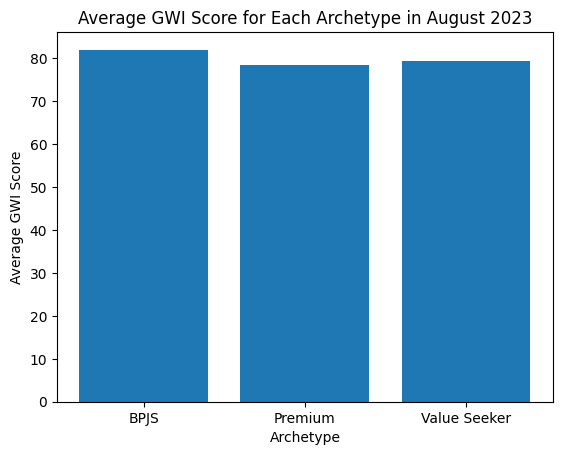

In [16]:
agent = Agent(
    gwi_score_connector,
    config={"llm": llm},
    description=description,
)
response = agent.chat("Berikan nilai rata-rata GWI Score untuk Setiap Archetype pada bulan Agustus 2023")
print(response)

'/Users/donnymirzaadhitama/workspace/others/chatbot-llm/exports/charts/temp_chart.png'

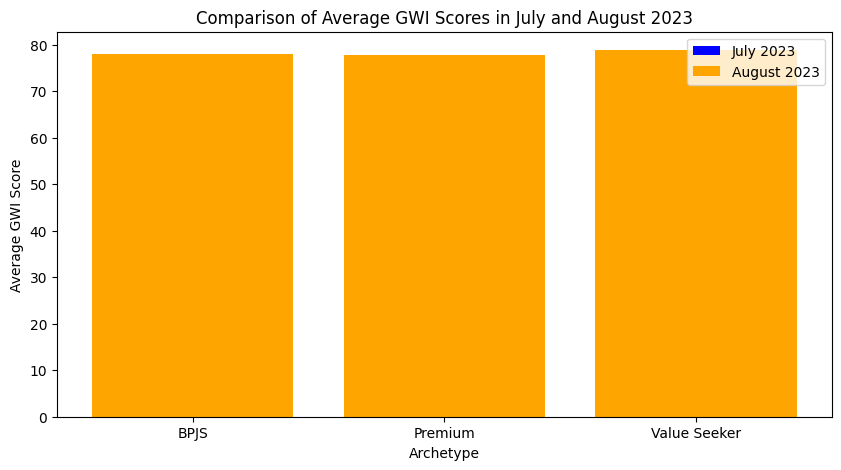

In [35]:
agent.chat("Bagaimana dengan bulan sebelumnya?")

In [36]:
explanation = agent.explain()
print(explanation)

 To generate the code, I first identified the request from the user, which was to compare the average GWI scores for each archetype in the previous month (July 2023) with the current month (August 2023).

I started by creating a dataframe for the previous month (July 2023) using the `query()` function to filter the data. Then, I calculated the average GWI score for each archetype in that month using the `groupby()` and `mean()` functions.

Next, I created a bar chart to visualize the average GWI scores for both July and August 2023. I used the `plt.bar()` function to create the bars and specified the colors and labels for each month. I also added labels to the x and y axes and a title to the chart.

Finally, I saved the chart as an image file using the `plt.savefig()` function and returned the path to the image file as the result.


In [37]:
print(agent.last_code_executed)

prev_month_df = dfs[0].query('month == 1 and year == 2023')
prev_month_gwi_score = prev_month_df.groupby('archetype')['gwi_score'].mean()
plt.figure(figsize=(10, 5))
plt.bar(prev_month_gwi_score.index, prev_month_gwi_score, color='blue', label='July 2023')
plt.bar(dfs[0].groupby('archetype')['gwi_score'].mean().index, dfs[0].groupby('archetype')['gwi_score'].mean(), color='orange', label='August 2023')
plt.xlabel('Archetype')
plt.ylabel('Average GWI Score')
plt.title('Comparison of Average GWI Scores in July and August 2023')
plt.legend()
plt.savefig('/Users/donnymirzaadhitama/workspace/others/chatbot-llm/exports/charts/temp_chart.png')
result = {'type': 'plot', 'value': '/Users/donnymirzaadhitama/workspace/others/chatbot-llm/exports/charts/temp_chart.png'}


## Add more tables

In [10]:
field_descriptions_indicator = {
    "organization_id": "id for organization/hospital",
    "hospital_name": "name of hospital such as Siloam Hospitals Lippo Village, Siloam Hospitals Kebon Jeruk, MRCCC Siloam Hospitals Semanggi, etc",
    "hospital_code": "code of hospital unit such as SHLV, SHKJ, MRCCC, etc",
    "hospital_region": "region of hospital, such as Region 1, Region 2, etc",
    "hospital_type": "type of hospital, such as Mature, Flagship, Distinct, BPJS, Ramping Up, and Hospital Services",
    "archetype": "archetype of hospital, such as Value Seeker, Premium, and BPJS",
    "hospital_group": "hospital group, such as Group 1, Group 2",
    "month": "month of year, such as 1, 2, 3, etc",
    "year": "year of data, such as 2023, 2022, etc",
    "month_year": "month and year of data, such as 12022, 22022, etc",
    "quarter_year": "quarter and year of data, such as Q1-2022, Q2-2022, etc",
    "semester_year": "semester and year of data, such as S1-2022, S2-2022, etc",
    "indicator_id": "id of indicator, such as C-DQ/0, C-DQ/1, etc",
    "target": "target of indicator value in numeric, such as 100.0, 90.0, 0.0 etc",
    "rules": "rules of indicator, such as >=, <=, and null",
    "avg_indicator_numerator_month": "average numerator of indicator value in month",
    "avg_indicator_denumerator_month": "average denominator of indicator value in month",
    "avg_num_result": "average result of indicator in month (avg_num_month/avg_denum_month)",
    "traffic_light_month": "traffic light of indicator in month, such as red, yellow, green, and null",
    "perspective": "perspective of indicator, such as Internal Process, Customer, Financial, and Learning & Growth",
    "category": "category of indicator, such as Clinical Governance, OPD Transformation, OPD Transformation - Goals, etc",
    "is_gwi_index": "indicator is GWI index or not",
    "unit": "unit of indicator, such as %, Minute, hours, Days, and null",
    "avg_indicator_result_month": "average indicator result value in month",
    "indicators": "names of indicator, such as Procedure Duration On Time, Call performance - Medical Check Up, etc",
    "indicators_": "information of target indicator such as *Call performance - Operator -- (Target = 80%), *Delayed Elective Surgery > 60 mins -- (Target = 5%), etc",
    "is_use": "indicator is used or not"
}

In [11]:
gwi_indicator_connector = GoogleBigQueryConnector(
    config={
        "credentials_path" : "service_account/dwh-siloam-99402e61edd2.json",
        "database" : "GWI_LLM",
        "table" : "indicator_result_view",
        "projectID" : "dwh-siloam",
        # "where": [
        #     # this is optional and filters the data to
        #     # reduce the size of the dataframe
        #     ["loan_status", "=", "PAIDOFF"],
        # ],
    },
    field_descriptions=field_descriptions_gwi,
)

In [12]:
field_descriptions_opd = {
	"patient_visit_id": "unique identifier for each patient visit",
	"PatientNameMYSILOAM": "patient's name as recorded in the MYSILOAM system",
	"PatientNameBIDWH": "patient's name as recorded in the MYSILOAM system",
	"organization_id": "id for organization/hospital",
	"hospital_region": "region of hospital, such as Region 1, Region 2, etc",
	"hospital_type": "type of hospital, such as Mature, Flagship, Distinct, BPJS, Ramping Up, and Hospital Services",
	"hospital_id": "alpha-numeric id for organization/hospital",
	"HospitalNameMYSILOAM": "hospital name as recorded in the MYSILOAM system, such as Siloam Hospitals Lippo Village, Siloam Hospitals ASRI, Siloam Hospitals Kelapa Dua, etc",
	"HospitalNameBIDWH": "hospital name as recorded in the BIDWH system, such as SHLV - Siloam Hospitals Lippo Village, ASRI - Siloam Hospitals Asri, RSUSKD - Siloam Hospitals Kelapa Dua, etc",
	"hospital_code": "code of hospital unit such as SHLV, ASRI, RSUSKD, etc",
	"new_time_zone": "time zone of the hospital, such as 07:00:00, 08:00:00, 09:00:00",
	"local_mr_no": "patient's medical record number at the local hospital",
	"admission_number": "admission number for the patient visit",
	"admission_hope_id": "unique identifier for the admission in the HOPE system",
	"AdmissionTypeId": "id for type of admission",
	"LOB": "line of business, such as MCU, OPD",
	"doctor_hope_id": "unique identifier for the doctor in the HOPE system",
	"DoctorNameMYSILOAM": "doctor's name as recorded in the MYSILOAM system",
	"DoctorNameBIDWH": "doctor's name as recorded in the BIDWH system",
	"queue_no": "queue number for the patient visit",
	"patient_type_MYSILOAM": "patient type as recorded in the MYSILOAM system, such as private, payer",
	"patient_type_MYSILOAM2": "patient type as recorded in the MYSILOAM system (additional information), such as private, payer",
	"patient_type_key": "key for the patient type, such as PAT",
	"patient_type_value": "value for the patient type, such as 2, 1, 5, 4",
	"patient_type_HOPE": "value for the patient type as recorded in the HOPE system, such as PAYER, PRIVATE, PASSPORT, KITAS",
	"get_queue_number_datetime": "date and time when the patient got their queue number",
	"registration_datetime": "date and time when the patient registered for their visit",
	"checkin_datetime": "date and time when the patient checked in for their visit",
	"input_visit_number_datetime": "date and time when the patient's visit number was inputted",
	"call_nurse_datetime": "date and time when the nurse was called to see the patient",
	"first_assessment_datetime": "date and time when the patient's first assessment was completed",
	"call_doctor_datetime": "date and time when the doctor was called to see the patient",
	"submit_sign_datetime": "date and time when the patient submitted their signature or in other definition is an SOAP (Subjective, Objective, Assessment and Plan) time",
	"input_pembayaran_datetime": "date and time when the patient's payment information was inputted",
	"call_cashier_datetime": "date and time when the cashier was called to process the payment",
	"hope_invoice_datetime": "date and time when the HOPE invoice was generated",
	"is_nurse_coord_pharmacy": "indicates whether the nurse coordinated with the pharmacy",
	"is_nurse_coord_cashier": "indicates whether the nurse coordinated with the cashier",
	"nurse_coord_pharmacy_datetime": "date and time when the nurse coordinated with the pharmacy",
	"nurse_coord_cashier_datetime": "date and time when the nurse coordinated with the cashier",
	"nurse_input_mr_datetime": "date and time when the nurse inputted the patient's medical record",
	"verify_prescription_datetime": "date and time when the prescription was verified",
	"confirm_worklist_datetime": "date and time when the worklist was confirmed",
	"call_worklist_datetime": "date and time when the worklist was called or in other terms is the pharmacy call time",
	"first_click_emr_doctor_datetime": "date and time when the doctor first clicked on the EMR",
	"appointment_date": "date of the patient's appointment",
	"appointment_time": "time of the patient's appointment",
	"admission_date": "date of the patient's admission",
	"admission_datetime": "date and time of the patient's admission",
	"admission_day": "date of the patient's admission",
	"admission_month": "month of the patient's admission",
	"admission_year": "year of the patient's admission",
	"billing_datetime": "date and time when the patient was billed",
	"processing_emr_pharmacy_datetime": "date and time when the EMR was processed by the pharmacy",
	"check_emr_pharmacy_datetime": "date and time when the EMR was checked by the pharmacy",
	"done_emr_pharmacy_datetime": "date and time when the EMR was completed by the pharmacy",
	"drug_status": "status of the patient's medication, such as Racikan, Non Racikan",
	"is_contactless": "indicates whether the patient's visit was contactless",
	"PayerNameMYSILOAM": "name of the patient's payer as recorded in the MYSILOAM system",
	"PayerNameBIDWH": "name of the patient's payer as recorded in the BIDWH system",
	"Archetype": "archetype of hospital, such as Value Seeker, Premium, and BPJS",
	"GroupId": "unique identifier for the patient's payer group, such as 4, 8, 3, 7, etc",
	"PayerNameGroupBI_SILOAM1": "name of the patient's payer group as recorded in the BI_SILOAM1 system, such as Third Parties - Insurance Government (Non-BPJS), Third Parties - Corporate, Third Partied - Corporate Guarantee, Third Parties - Employee, etc",
	"PayerNameGroupBI_SILOAM2": "name of the patient's payer group as recorded in the BI_SILOAM2 system, such as BPJS, OPE, KMK, Government, etc",
	"PayerGroupCode": "code for the patient's payer group, such as 140, 213, 120, etc",
	"user_regis": "user who registered the patient",
	"queue_line_regis": "queue line where the patient was registered, such as FO Ruang Kaca, Antrian Touchless SHLC, Antrian Touchless SHPL, Sunday / Holiday Clinic, etc",
	"button_name_regis": "name of the button clicked to register the patient, such as P. Medis, CUSTOMER SERVICE, E. BPJS Walk-in Poli Pagi, Sudah Bayar, etc",
	"first_assessment_user": "user who performed the patient's first assessment",
	"first_click_doctor_datetime": "date and time when the doctor first clicked on the patient's record",
	"is_express_checkout": "indicates whether the patient used express checkout",
	"store_loc": "location of the store where the patient picked up their medication, such as PHARMACY PEDIATRIC, PHARMACY 2F OPD, PHARMACY CENTRAL 2ND FLOOR, PHARMACY EXPIRED, etc",
	"pharmacy_user": "user who processed the patient's medication order",
	"user_cashier": "user who processed the patient's payment",
	"queue_line_cashier": "queue line where the patient paid for their medication, such as Poli Bedah, Kasir Front Office, SHASRI FO LT.2, Sunday / Holiday Clinic, OPD UMUM, etc",
	"button_name_cashier": "name of the button clicked to process the patient's payment, such as PLN, Kasir Jaminan Vida, Kasir VIDA (ASURANSI), Kasir Jaminan SHG, etc",
	"cancel_reason": "reason for the patient's visit being cancelled",
	"is_rad": "indicates whether the patient had radiology services during their visit",
	"is_lab": "indicates whether the patient had laboratory services during their visit",
	"is_pharmacy": "indicates whether the patient had pharmacy services during their visit",
	"add_medical_order_time": "date and time when the medical order was added",
	"user_phar_verify": "user who verified the patient's prescription",
	"counter_farmasi": "counter where the patient picked up their medication, such as Floor 0 - Farmasi, Floor Mezzanine - Farmasi, Floor - Farmasi, Floor 7 - Farmasi, etc",
	"craft_group": "craft group of the patient's visit, such as Kedokteran Nuklir, Andrologi, Kedokteran Okupasi, Pediatri (Anak), etc",
	"craft_group2": "craft group of the patient's visit (additional information), such as SURGERY, CARDIOLOGY, ANESTHESIOLOGY, NUCLEAR MEDICINE, etc",
}

In [13]:
opd_connector = GoogleBigQueryConnector(
    config={
        "credentials_path" : "service_account/dwh-siloam-99402e61edd2.json",
        "database" : "OPD",
        "table" : "Operational_Dashboard",
        "projectID" : "dwh-siloam",
        # "where": [
        #     # this is optional and filters the data to
        #     # reduce the size of the dataframe
        #     ["loan_status", "=", "PAIDOFF"],
        # ],
    },
    field_descriptions=field_descriptions_opd,
)

In [14]:
embedding_model = VertexAIEmbeddings(
    model_name=config.GCP_EMBEDDING_MODEL_NAME, 
)

In [33]:
prompt = """
You will be asked a question in Indonesian language.
You need to answer the question also in Indonesian.
If you provide a table or chart or both of them in the answer, you have to give an explanation and analyze it using your own reasoning in Indonesian language.

Question: {question}
"""

In [34]:
# vectorstore = ChromaDB(
#     collection_name="gwi_kb",
#     embedding_model=embedding_model,
# )

with open("dataset/GWI_KB_25_Mar_2024.txt", "r") as f:
    docs = f.read()

agent = Agent(
    [
        gwi_score_connector, 
        gwi_indicator_connector,
        opd_connector,
    ],
    config={
        "llm": llm,
        "verbose": True,
    },
    description=description,
    # vectorstore=vectorstore,
)
# agent.train(docs=docs)

question = "Berikan nilai rata-rata GWI Score untuk Setiap Archetype pada Mei 2023"
response = agent.chat(prompt.format(question=question))
print(response)

      archetype  gwi_score
0          BPJS  84.220152
1       Premium  81.359223
2  Value Seeker  81.208348


In [28]:
question = """
Bagaimana result indikator C-AO/32 pada hospital code SHSB di bulan maret 2024 jika dibandingkan dengan result bulan-bulan sebelumnya?
"""
response = agent.chat(question)
print(response)

        organization_id               hospital_name hospital_code  \
101638                5   Siloam Hospitals Surabaya          SHSB   
102890                5   Siloam Hospitals Surabaya          SHSB   
103089                5   Siloam Hospitals Surabaya          SHSB   
103090                5   Siloam Hospitals Surabaya          SHSB   
103288                5   Siloam Hospitals Surabaya          SHSB   
104037                5   Siloam Hospitals Surabaya          SHSB   

       hospital_region hospital_type archetype  month  month_year  \
101638        Region 3        Mature   Premium      3       32024   
102890        Region 3        Mature   Premium      1       12024   
103089        Region 3        Mature   Premium      1       12023   
103090        Region 3        Mature   Premium      2       22024   
103288        Region 3        Mature   Premium      3       32023   
104037        Region 3        Mature   Premium      2       22023   

       quarter_year semester_yea

In [29]:
code = agent.last_code_executed
print(code)

df_filtered = dfs[1][(dfs[1]['hospital_code'] == 'SHSB') & (dfs[1]['indicator_id'] == 'C-AO/32')]
df_filtered = df_filtered[df_filtered['month'].isin([1, 2, 3])]
result = {'type': 'dataframe', 'value': df_filtered}


In [46]:
import pandasai
pandasai.__version__

'2.0.43'